In [1]:
%matplotlib tk

import numpy as np
import torch
import matplotlib.pyplot as plt
import plotly.express as px
import brainflow as bf
from scipy.signal import butter,lfilter
from scipy.fft import fft, fftfreq, fftshift
import plotly.io as pio
import plotly.graph_objects as go
import mne


## Using Raw data

In [2]:
filename = 'Raw_P1_reoorganised2.npz'
train = np.load(f'/media/mangaldeep/HDD2/workspace/MotionControl_MasterThesis/data/{filename}', allow_pickle=True)
train_x = np.float64(train['arr_0'])
event_t = train['arr_1']
train_y = train['arr_2']

In [3]:
sfreq = 80.0
ch_names = ['Fp1','Fp2','C3', 'C4','P7', 'P8', 'O1', 'O2', 'F7', 'F8','F3', 'F4','T9','T10', 'P3', 'P4']
ch_types = ['eeg'] * 16
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types);
raw = mne.io.RawArray(train_x, info);
locinfo = mne.io.read_raw_fif('/media/mangaldeep/HDD2/workspace/MotionControl_MasterThesis/main/extraction/Physionet_ChLoc_raw.fif', preload = False)
locinfo.pick_channels(raw.ch_names)
raw._set_channel_positions(locinfo._get_channel_positions(), locinfo.ch_names)
# raw.plot_sensors(show_names = True);
# locinfo.plot_sensors(show_names = True)

Creating RawArray with float64 data, n_channels=16, n_times=144000
    Range : 0 ... 143999 =      0.000 ...  1799.987 secs
Ready.
Opening raw data file /media/mangaldeep/HDD2/workspace/MotionControl_MasterThesis/main/extraction/Physionet_ChLoc_raw.fif...
    Range : 0 ... 19679 =      0.000 ...   122.994 secs
Ready.


In [5]:
raw._data.shape

(16, 144000)

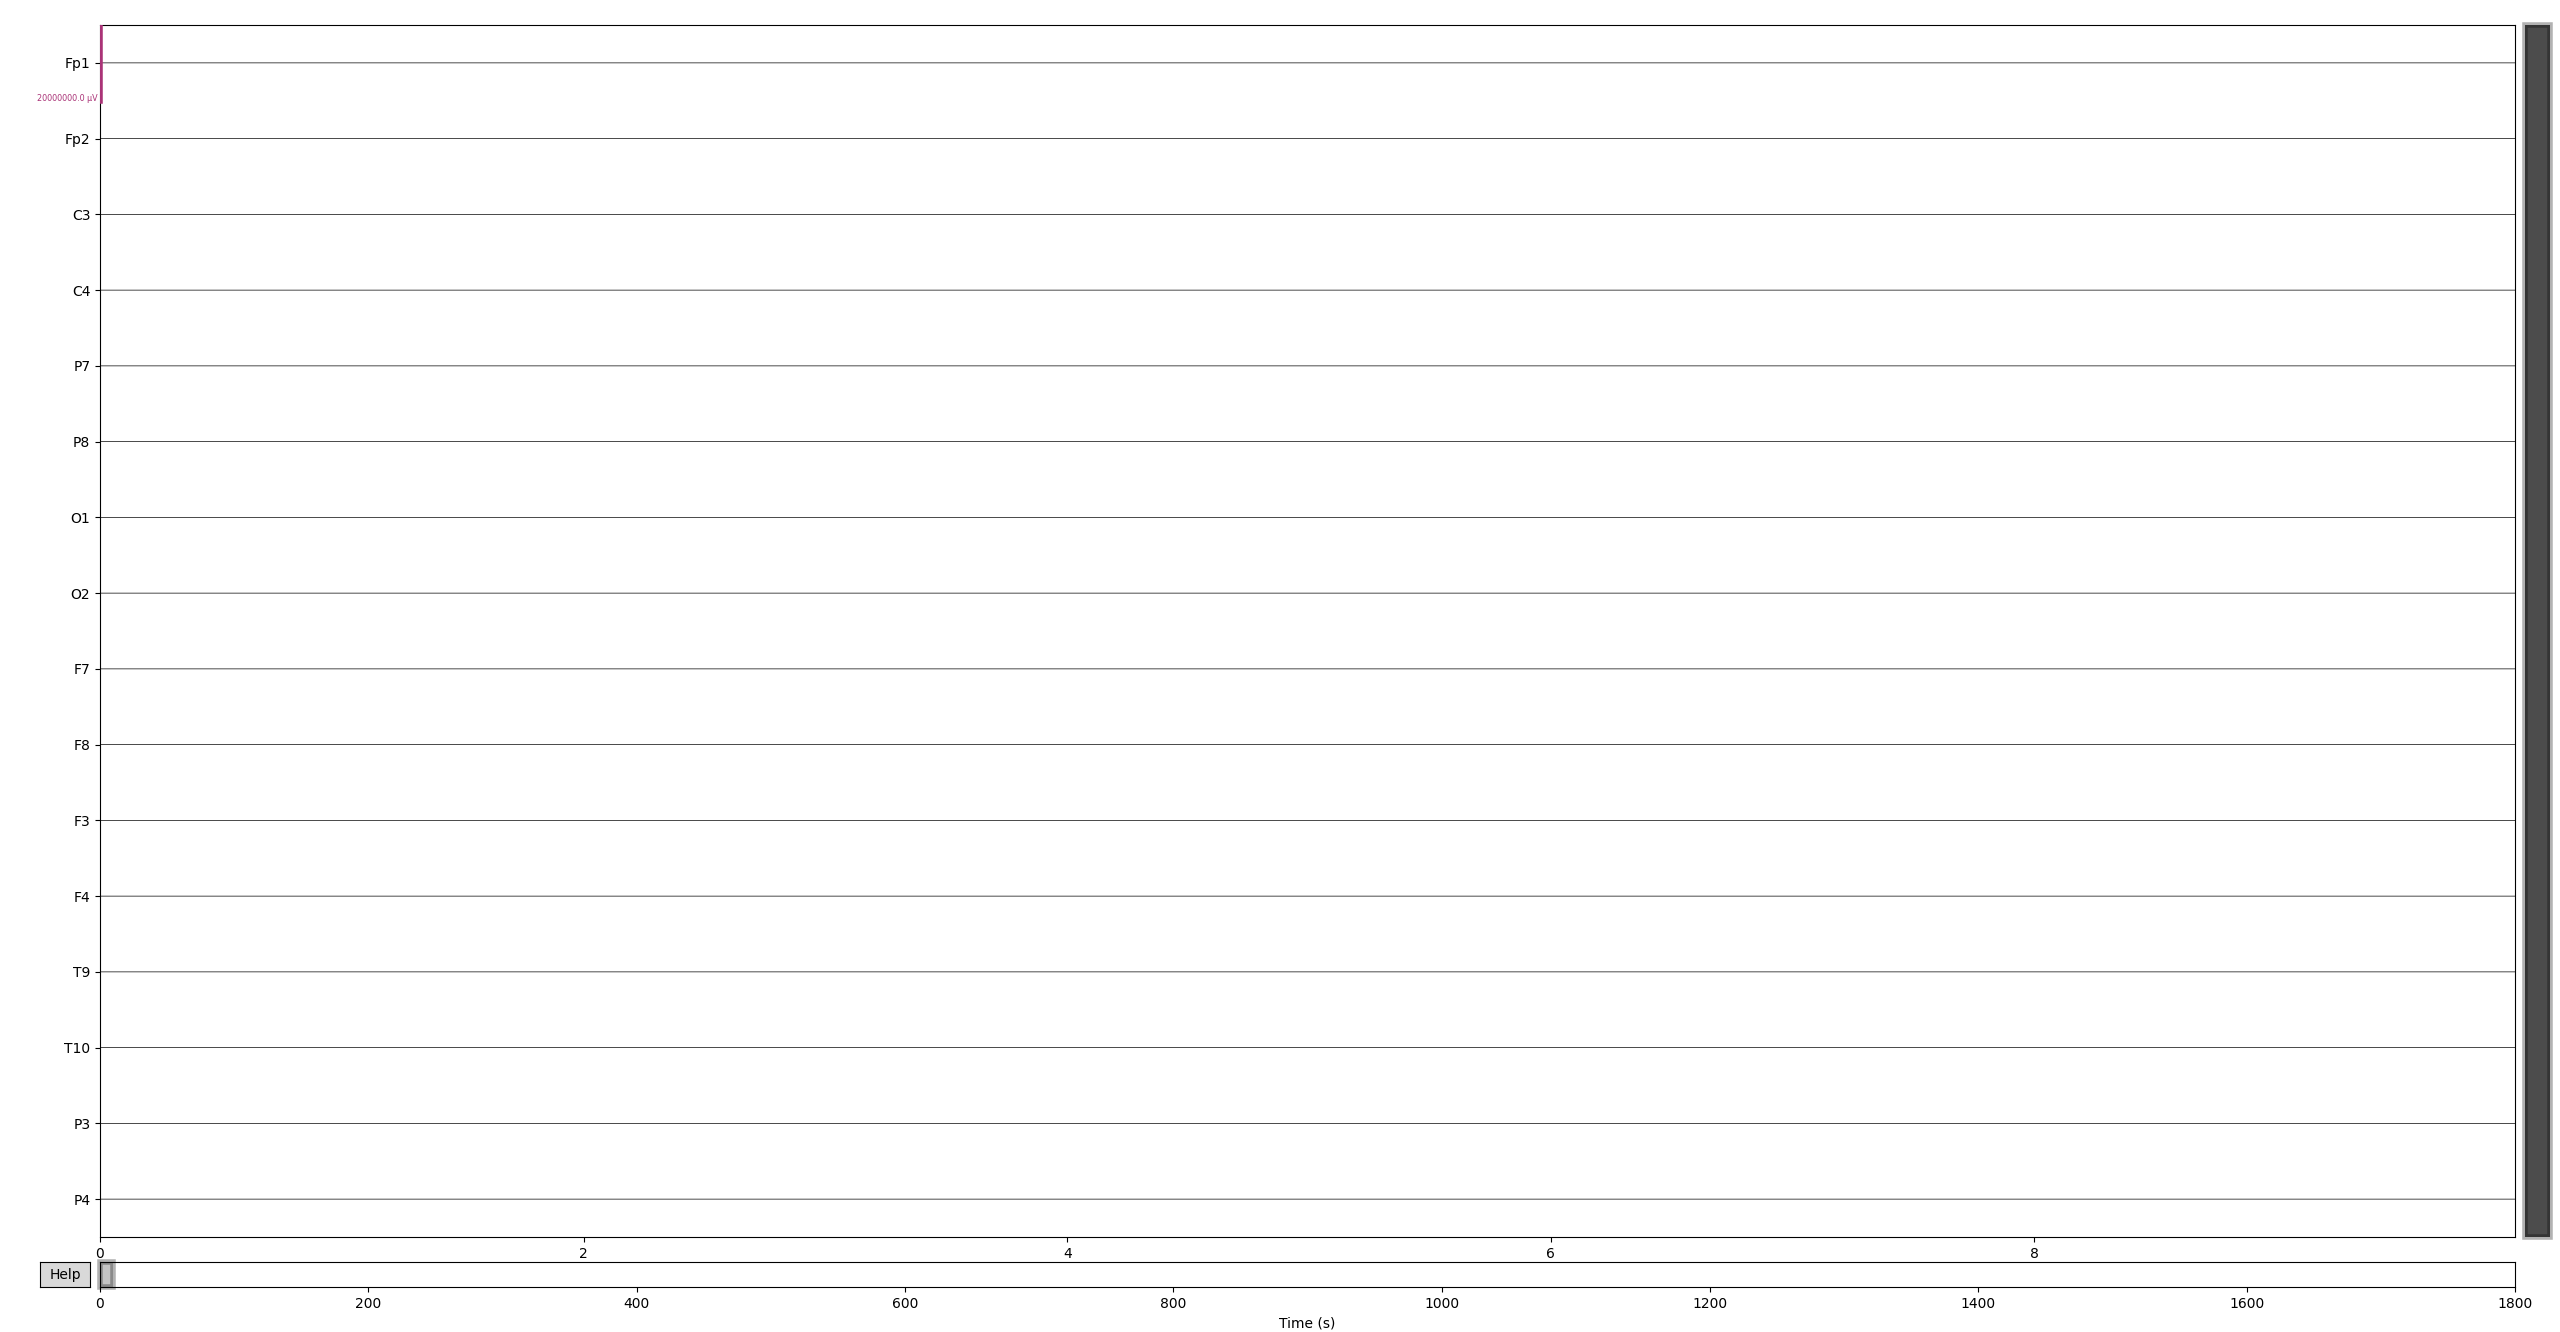

Effective window size : 25.600 (s)


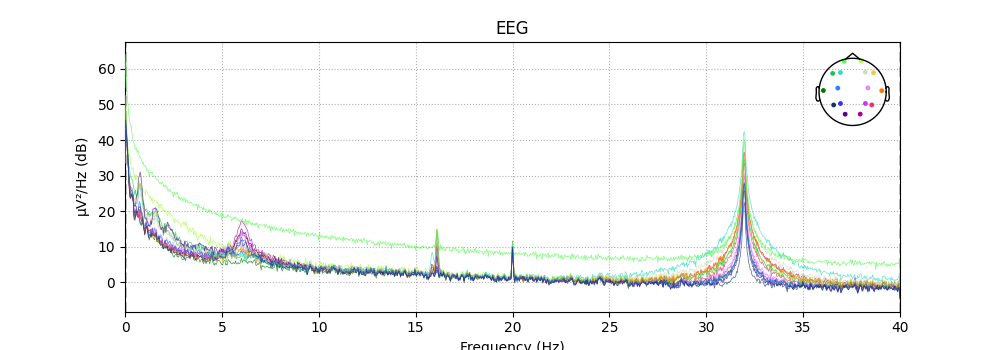

In [4]:
scal = dict(mag=1e-12, grad=4e-11, eeg=10000000e-6)
raw.plot(scalings = scal);
raw.plot_psd();

In [7]:
rawfltrd = raw.filter(5, 39, verbose= False, fir_design='firwin', skip_by_annotation='edge').copy()
scal = dict(mag=1e-12, grad=4e-11, eeg=1000e-6)
rawfltrd.plot(scalings = scal);
rawfltrd.plot_psd();

Effective window size : 25.600 (s)


In [8]:
def normalize(train_x):
    for j in range(train_x.shape[0]):
        # try:
        #     train_x[j,:]-= np.mean(train_x[j,:])
        #     train_x[j,:] = (train_x[j,:]/np.std(train_x[j,:]) )/3
        # except Exception as e:
        #     train_x[j,:] =0
        train_x[j,:] = (train_x[j,:] - train_x[j,:].min()) / (train_x[j,:].max() - train_x[j,:].min())
    return train_x

raw_nrm = normalize(rawfltrd.get_data())
raw_nrm = mne.io.RawArray(raw_nrm, info);

Creating RawArray with float64 data, n_channels=16, n_times=144000
    Range : 0 ... 143999 =      0.000 ...  1799.987 secs
Ready.


In [9]:
# event_t = [961*i for i in range(len(train_y))]
event_data = np.uint16(np.column_stack((event_t, np.zeros((len(train_y,))),train_y)))
event_marker, event_id = event_data[:,0],event_data[:,2]
# idx = event_marker[:,-1].argsort()
# event_marker = event_marker[idx,:]
reject = dict(    eeg=20000000000e-6)     # unit: V (EEG channels))
event_ids = dict({'right':0, 'left':1, 'none':2}) # Replacing the existing event ids
# epochs1 = mne.Epochs(rawfltrd, events= event_marker, event_id= event_ids, baseline = (0,0))
epochs = mne.Epochs(rawfltrd, events= event_data, tmin= -1, tmax= 6, event_id= event_ids,reject = None,
        verbose= True, proj= False) ;# Baseline is default (None,0)
x_epoch = epochs.get_data()

Not setting metadata
Not setting metadata
150 matching events found
Setting baseline interval to [-1.0, 0.0] sec
Applying baseline correction (mode: mean)
Loading data for 150 events and 561 original time points ...
7 bad epochs dropped


Channels marked as bad: none


In [11]:
mne.annotations_from_events(event_data,sfreq=80)

<Annotations | 150 segments: 0 (50), 1 (50), 2 (50)>

In [16]:
# scal = mne.decoding.Scaler(info=info, scalings='median', with_mean=True, with_std=False)
# dd = scal.fit_transform(epochs.get_data(), train_y)
# dd.shape
clas = 'left'

# epochs['right'].plot_image(combine = 'mean', title = 'right');
epochs[clas].average().plot_image(show_names = 'all', titles = clas, picks = ch_names);
# epochs[clas].plot_topo_image(layout=layout, title = clas);
epochs[clas].plot_image(title = clas, combine = 'mean');
epochs[clas].plot_psd();

Loading data for 49 events and 121 original time points ...
Not setting metadata
Not setting metadata
49 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped
combining channels using "mean"
Loading data for 49 events and 121 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


In [ ]:
[raw_nrm[1,:].max()- raw_nrm[1,:].min() for i in range(16)]

## Using Recorded Epoched data

In [ ]:
def removeOutlier(train_x):
    for ch in range(train_x.shape[0]):
        data = train_x[ch,:].copy()
        d25, d75 = np.percentile(data,10), np.percentile(data,90)
        iqr = d75 - d25
        iqr_cut = iqr *1.5
        low, up = d25 - iqr, d75 + iqr
        idx = np.where(np.logical_or(data < low, data> up))
        train_x[ch,idx] = np.median(data)
    return train_x

def bandpassFilter(train_x):
    for j in range(16):
        order, ripple = 5, 0.5
        lf, hf = 1,39
        fs = 80 # Actually 80
        b, a = butter(order, [lf, hf], fs=fs, btype='band')
        train_x[j,:] = lfilter(b, a, train_x[j,:])
        # bf.DataFilter.perform_bandpass(train_x[j,:], fs, lf, hf,order, 1, ripple=ripple)
    return train_x
    
def plotFFT(train_x, i):
    # Number of samplepoints
    y = train_x[i,:]
    N = 80
    # sample spacing
    # x = np.linspace(0.0, 1, N)
    # y = np.sin(10.0 * 2.0*np.pi*x) + 0.5*np.sin(20.0 * 2.0*np.pi*x)
    yf = fft(y)
    xf = np.linspace(0.0, N/2, N//2)

    fig, ax = plt.subplots()
    ax.semilogy(xf, 2.0/N * np.abs(yf[:N//2]))
    plt.show()

def epochData(train_x):
    ep,_,_,ts = train_x.shape
    arr = np.split(train_x, ep, axis = 1)
    train_x = np.stack(arr)
    return train_x

def plotComparison(x_1shot, x_bf, x_clean, i):
    # plt.plot(np.arange(x_1shot.shape[1]),x_1shot[i,:],np.arange(x_1shot.shape[1]),x_clean[i,:], np.arange(x_1shot.shape[1]),x_bf[i,:])
    x = np.arange(x_1shot.shape[1])
    fig = go.Figure()

    fig.add_trace(go.Scatter(x=x, y=x_1shot[i,:],
                        mode='lines',
                        name='Raw'))
    fig.add_trace(go.Scatter(x=x, y=x_bf[i,:],
                        mode='lines+markers',
                        name='BandPassFiltered'))
    fig.add_trace(go.Scatter(x=x, y=x_clean[i,:],
                        mode='lines',
                        name='Outlier removed'))

    fig.show()

def normalize(train_x):
    for j in range(train_x.shape[0]):
        # try:
        #     train_x[j,:]-= np.mean(train_x[j,:])
        #     train_x[j,:] = (train_x[j,:]/np.std(train_x[j,:]) )/3
        # except Exception as e:
        #     train_x[j,:] =0
        train_x[j,:] = (train_x[j,:] - train_x[j,:].min()) / (train_x[j,:].max() - train_x[j,:].min())
    return train_x

In [ ]:
filename = 'P1_Trial2.npz'
train = np.load(f'/media/mangaldeep/HDD2/workspace/MotionControl_MasterThesis/data/train/{filename}', allow_pickle=True)
train_x = np.float64(train['arr_0'])
raw_data = train_x.copy()
train_y = train['arr_1']
# pio.renderers.default = 'plotly_mimetype+notebook'
# print(pio.renderers.default)

In [ ]:
print(train_x.shape)
print(train_y.shape)
x_1shot = np.hstack(train_x.squeeze(1))
x_bf = bandpassFilter(x_1shot.copy())
x_clean = removeOutlier(x_bf.copy())
print(x_1shot.shape)
# [x_1shot[i,:].max() - x_1shot[i,:].min() for i in range(16)]

In [ ]:
x_nrm = normalize(x_clean.copy())
x_nrm[[12,14],:] =0
x_epoch = epochData(x_nrm.copy())
x_epoch = torch.tensor(x_epoch).unsqueeze(dim=1)

In [ ]:
x_nrm[12,:]

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(x_epoch.shape[-1]),y = x_epoch[1,0,15,:]))
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(x_1shot.shape[1]),y = x_nrm[0,:]))
fig.show()

In [ ]:
plotFFT(x_clean.copy(), 10)

In [ ]:
plotComparison(x_1shot, x_bf,x_clean,12)

## Test Train Split

In [32]:
print(x_epoch.shape)
print(epochs.events[:,-1].shape)

(143, 16, 561)
(143,)


In [36]:
from sklearn.model_selection import train_test_split

# from data.params import OCIParams
datadir = "/media/mangaldeep/HDD2/workspace/MotionControl_MasterThesis/data"
EXPR_NAME = 'Processed_'+filename

# dCfg = OCIParams()
x_epoch = np.expand_dims(x_epoch, axis=1)
train_x,test_x,train_y,test_y = train_test_split(x_epoch, np.float16(epochs.events[:,-1]), test_size= 0.1,
                                stratify= epochs.events[:,-1], random_state= 42)
# print(channel_datas.shape)
print(f"saving data...")
# labels = labels[ACTION]*np.ones(self.TOTAL_ITERS)
np.savez(f'{datadir}/train/{EXPR_NAME}',train_x, train_y)
np.savez(f'{datadir}/test/{EXPR_NAME}',test_x, test_y)

saving data...


In [ ]:
scal = dict(mag=1e-12, grad=4e-11, eeg=1000000e-6)
raw.plot(scalings = scal);